<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/coo_to_coo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import DataFrame, read_csv, concat, set_option
set_option('display.max_columns', None)
set_option('display.max_rows', None)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
from numpy import nan, linspace, min, max, reshape, mean, std, int16, float32
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
!pip install shap
from shap import initjs, TreeExplainer, summary_plot, force_plot
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from scipy.stats import t, jarque_bera
!pip install researchpy
from researchpy import summary_cont
from gc import collect
from joblib import dump
from IPython.display import clear_output
clear_output()

In [ ]:
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep pandas_profiling
!pip list | grep matplotlib
!pip list | grep plotly
!pip list | grep scikit-learn
!pip list | grep scipy
!pip list | grep statsmodels
!pip list | grep researchpy
!pip list | grep shap
!pip list | grep catboost
!pip list | grep joblib
!pip list | grep ipython

numpy                         1.18.5         
pandas                        1.0.5          
pandas-datareader             0.8.1          
pandas-gbq                    0.11.0         
pandas-profiling              2.8.0          
sklearn-pandas                1.8.0          
matplotlib                    3.2.2          
matplotlib-venn               0.11.5         
plotly                        4.4.1          
scikit-learn                  0.22.2.post1   
scipy                         1.4.1          
statsmodels                   0.10.2         
researchpy                    0.2.3          
shap                          0.36.0         
catboost                      0.24.1         
joblib                        0.16.0         
ipython                       5.5.0          
ipython-genutils              0.2.0          
ipython-sql                   0.3.9          


In [ ]:
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_PHA.csv',
              
              dtype={'X1': 'int16',
                     'Y1': 'int16',
                     'X2': 'int16',
                     'Y2': 'int16',
                     'Area': 'int16',
                     'long': 'float32',
                     'lat': 'float32',},
              
              low_memory=True,
              usecols='Y1 Area lat'.split())
             
data = create_table(df.head())
data.show()

In [ ]:
del data
collect() # Garbage collection

19091

In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
del tail
collect()

19318

In [ ]:
df1, df2 = df.head(), df.tail()
conc_data_row = concat([df1,
                        df2,],
                        axis=0, # Row-wise operation
                        join='outer',) # Returns both dataframes' columns

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

22300

In [ ]:
assert df['Y1'].notnull().all()
assert df['Area'].notnull().all()
assert df['lat'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


Y1     NaN
Area   NaN
lat    NaN
dtype: float64

In [ ]:
df.drop_duplicates(subset=df.columns.values[:-1],
                   keep=False, # Drop all duplicates
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 3) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5,
               how='all', # Only drop columns when all values are NA
               axis='columns',)
df.shape

(18, 3)

In [ ]:
df.info(verbose=True,
        memory_usage='deep',) # Actual memory usage calculation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y1      18 non-null     int16  
 1   Area    18 non-null     int16  
 2   lat     18 non-null     float32
dtypes: float32(1), int16(2)
memory usage: 272.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='Coo-Coo Report',
                        explorative=True, # Deeper data insights
                        progress_bar=True,)
profile.to_notebook_iframe() # Display report in output console

In [ ]:
del profile
collect()

59424

In [ ]:
# Calculating t-statistic
sample_size = 18
print(t.ppf(1-0.025, sample_size - 1))

2.1098155778331806


In [ ]:
# Checking the distribution of the target variable
DataToTest = df['lat']
stat, p = jarque_bera(DataToTest)
print(f'stat={stat}', 
      f'p={p}')

if p > 0.05:
    print('Normal distribution')
else:
    print('Not a normal distribution')

stat=1.1163851560715445 p=0.5722424132248507
Normal distribution


In [ ]:
summary = summary_cont(df[['Y1',
                           'Area',
                           'lat',]])

summary = create_table(summary)
summary.show()

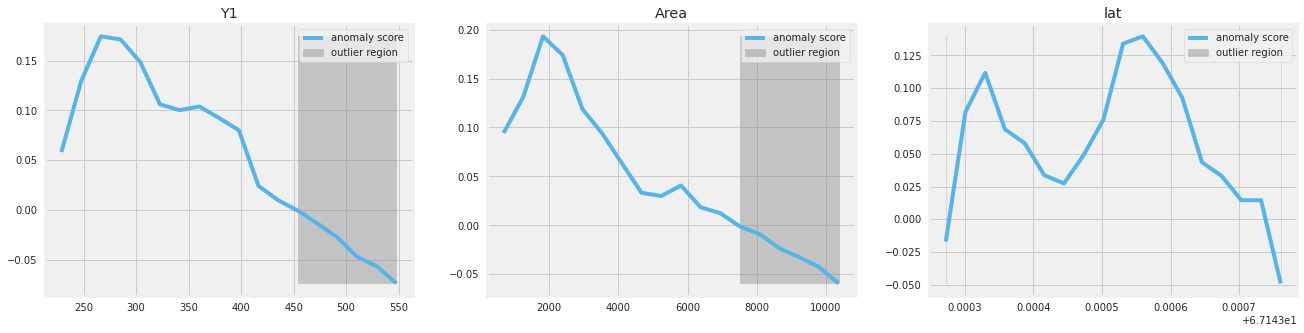

In [ ]:
cols = df
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),)

fig.set_facecolor('w')
fig.set_edgecolor('k')
axs = axs.reshape(-1) # Return a 1D array

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.1) # Outlier thresh
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1)) # 2D array

    xx = linspace(df[column].min(), # Starting value of the sequence
                  df[column].max(), # End value of the sequence
                  len(df), # No. of samples to generate
                  endpoint=True,).reshape(-1, 1)

    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',
                color='#56B4E9',)
    
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score), # Minimum boundary
                        max(anomaly_score), # Maximum boundary
                        where=outlier==-1, # Threshold to fill in a curve
                        color='grey', # Fill color
                        alpha=.3, # Opacity
                        label='outlier region',)
    
    axs[i].legend(frameon=True) # Show box enclosing the legend text
    axs[i].set_title(column,
                     loc="center",)

In [ ]:
# Define predictor (X) and target variables (y)
X = df[['Y1',
        'Area',]]
        
y = df['lat'].to_numpy().reshape(-1, 1)

The predictor variables defined above (Y1, MPY, and Area) were determined through SHAP, Recursive Feature Elimination (RFE), feature importance, and Variance Inflation Factor (VIF). The following code is not a direct part of this notebook. The reason I've not included this code as a direct part of the notebook is due to the fact that RFE requires all features (columns) to be included which I'm not a fond of since after the RFE process, I'll have to update related variables.



```
from numpy import int16, float32
from pandas import DataFrame, read_csv
from plotly.figure_factory import create_table
!pip install catboost
from catboost import CatBoostRegressor
!pip install shap
from shap import initjs, TreeExplainer, summary_plot, force_plot
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Show data
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_PHA.csv',
              
              dtype={'X1': 'int16',
                     'Y1': 'int16',
                     'X2': 'int16',
                     'Y2': 'int16',
                     'MID_POINT_X': 'float32',
                     'MID_POINT_Y': 'float32',
                     'Area': 'int16',
                     'long': 'float32',},
              
              low_memory=True,)

# Create new features
df['MPX'] = (df['X1'] + df['X2']) / 2
df['MPX'] = df['MPX'].astype(
df['MPY'] = (df['Y1'] + df['Y2']) / 2

data = create_table(df.head())
data.show()

# Define predictor (X) and target variables (y)
X = df[['X1', 'Y1', 'X2', 'Y2',
        'MPX', 'MPY', 'Area', 'long',]]

y = df['lat'].to_numpy().reshape(-1, 1)

# Define the model
regr = CatBoostRegressor(iterations=7000, 
                         depth=4, 
                         learning_rate=0.02, 
                         loss_function='RMSE', 
                         subsample=0.9,
                         grow_policy='Depthwise',
                         l2_leaf_reg=2,
                         rsm=0.9,
                         verbose=0,)

# SHAP
X_sampled = X.sample(10,
                     random_state=10,)
 
explainer = TreeExplainer(regr)
shap_values = explainer.shap_values(X_sampled)
 
initjs()
force_plot(explainer.expected_value,
           shap_values[0,:],
           X_sampled.iloc[0,:],)
________________________________________________________________________________
 
initjs()
force_plot(explainer.expected_value,
           shap_values,
           X,)
________________________________________________________________________________
 
summary_plot(shap_values,
             X_sampled,)
________________________________________________________________________________
 
summary_plot(shap_values, 
             X_sampled, 
             plot_type="bar",)
________________________________________________________________________________

# Performing RFE
rfe = RFE(regr, 3)
fit = rfe.fit(X, y,)
print("Num features: {}".format(fit.n_features_))
print("Selected features: {}".format(fit.support_))
print("Feature ranking: {}".format(fit.ranking_))
________________________________________________________________________________
Output: Num features: 3
        Selected features: [False  True False False False  True  True False]
        Feature ranking: [5 1 2 3 4 1 1 6]
________________________________________________________________________________
# Calculating feature importance
regr.fit(X, y,)
print(regr.feature_importances_)
________________________________________________________________________________
Output: [ 9.16290081 18.84564741 12.5639984  11.02915573 10.14992198 19.3244022
          15.43551419  3.48845928]
________________________________________________________________________________
# Train and test parameters
def calc_vif(X):

    # Calculating VIF
    vif = DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(X)
```



In [ ]:
imp = KNNImputer(missing_values=nan, # Missing values marked as nan
                 n_neighbors=5, # No. of nearby values
                 weights='distance', # Nearest value = Greatest influence
                 metric='nan_euclidean',)

In [ ]:
regr = CatBoostRegressor(iterations=7000, 
                         depth=4, 
                         learning_rate=0.09, 
                         loss_function='RMSE', 
                         subsample=0.9,
                         grow_policy='Depthwise',
                         l2_leaf_reg=2,
                         rsm=0.9,
                         verbose=0,)

In [ ]:
pipeline = make_pipeline(imp, regr)
pipeline.fit(X, y.reshape(-1),)

Pipeline(memory=None,
         steps=[('knnimputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='distance')),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7faa80598ef0>)],
         verbose=False)

In [ ]:
dump(pipeline, 'pipeline.joblib') # Save pipeline file on your device

['pipeline.joblib']

In [ ]:
scores = cross_val_score(pipeline,
                         X, y.reshape(-1),
                         cv=18, # 18-fold split
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1,) # Use every CPU core
print(scores)

[-1.01475410e-05 -1.67845965e-04 -7.92467268e-05 -3.05170663e-05
 -1.29561369e-04 -7.63096263e-06 -3.81456872e-05 -1.08704726e-05
 -1.01068806e-04 -5.74620087e-05 -1.67845720e-04 -6.26715036e-05
 -5.83156634e-10 -3.81461937e-05 -5.28459054e-10 -3.05156326e-05
 -1.52597739e-05 -1.52577424e-05]


In [ ]:
mean_scores, std_scores = (-1 * scores.mean(), scores.std())
print(f'RMSE: {mean_scores:.6f}',
      f'SD: {std_scores:.4f}')

RMSE: 0.000053 SD: 0.0001
